In [ ]:

!nvidia-smi

Wed Nov 26 07:50:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off |   00000000:B2:00.0 Off |                  N/A |
| 33%   54C    P2            246W /  250W |    2112MiB /  11264MiB |     99%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
# NOTE!
# this is for a multi-gpu setup. we basically set which GPU is visible for the program.
# if you only have one GPU (most likely the case ;) ), make sure this is set to "0"!
# or remove this line completely!
# otherwise you may accidentally make your GPU "invisible" to the program!
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Data, Model, Training

In [3]:
import os
os.chdir("/home/exgr5/LGM/Assignments")
print(os.getcwd())

/home/exgr5/LGM/Assignments


In [29]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn

from lgm.common import count_parameters, plot_learning_curves, EMA
from lgm.data import get_datasets_and_loaders, N_CLASSES, Normalize
from lgm.evaluation import get_classifier, fid, inception_score_with_features
from lgm.layers import CNNBody, Reshape, ConvBlockPrenorm
from lgm.vae import ConditionalVAETrainer, ConditionalVAEGauss, ConditionalNet
from lgm.gan.model import Discriminator, Generator, GAN
from lgm.gan.trainer import GANTrainer
torch.set_float32_matmul_precision('high')
torch.backends.cudnn.benchmark = True

Shape/dtype of batch X [N, C, H, W]: torch.Size([256, 1, 32, 32]), torch.float32
Shape/dtype of batch y: torch.Size([256]), torch.int64


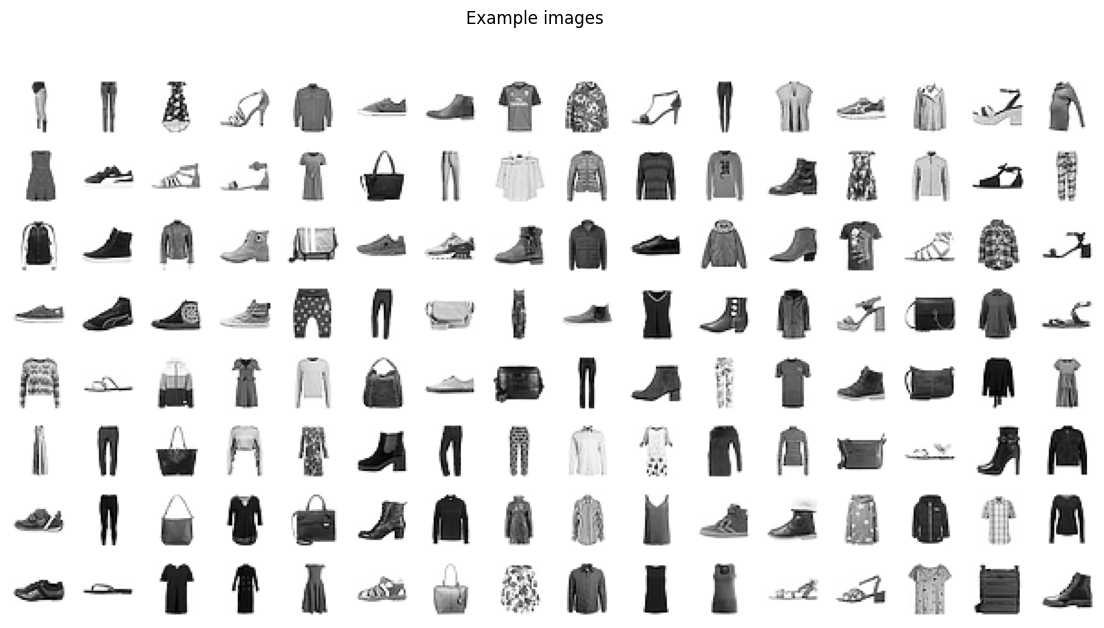

Shape/dtype of batch X [N, C, H, W]: torch.Size([256, 1, 32, 32]), torch.float32
Shape/dtype of batch y: torch.Size([256]), torch.int64


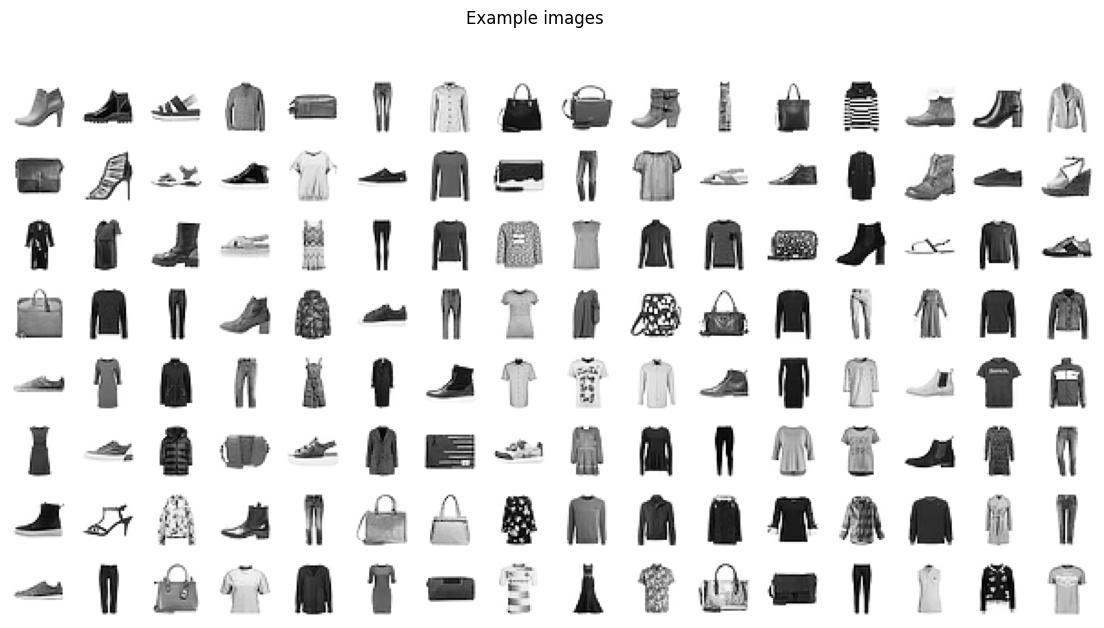

In [68]:
data = "fashion"
batch_size = 256
train_data_vae, test_data_vae, train_dataloader_vae, test_dataloader_vae = get_datasets_and_loaders(data, batch_size, num_workers=16)
def descale_data(imgs):
    return 0.5 * (imgs + 1)

train_data, test_data, train_dataloader, test_dataloader = get_datasets_and_loaders(data, batch_size, num_workers=16,
                                                                                    additional_transforms=[Normalize(0.5, 0.5)],
                                                                                    plot_descale=descale_data)

# Conditional and Unconditional Variational Autoencoder Training


In [74]:
def build__vae(CONDITIONAL = True):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using {device} device\n")
    
    level_filters = [32, 64, 128, 256]
    level_strides = [1, 2, 2, 2]
    blocks_per_level = 1
    kernel_size = 3
    activation = nn.Mish
    n_levels = len(level_filters)
    
    code_dim = 128
    flatten_code = True
    
    input_shape = next(iter(train_dataloader_vae))[0].shape[1:]
    input_pixels = input_shape[1]
    final_pixels = input_pixels // (2**(n_levels-1))  # each level after the first applies stride of 2
    
    input_channels = input_shape[0]
    final_filters = level_filters[-1] 
    
    class_dim = 32
    n_classes = N_CLASSES[data]
    
    block_fn = ConvBlockPrenorm
    block_kwargs = {"n_layers": 2, "activation": activation, "kernel_size": kernel_size,
                    "use_se": True, "se_reduction_factor": 8, "se_bias": 1.,
                    "use_residual": True, "bottleneck_factor": 1,
                    "cond_dim": class_dim if CONDITIONAL else 0}
    
    class_net = nn.Embedding(n_classes, class_dim)
    
    encoder_root = nn.Conv2d(input_channels, level_filters[0], kernel_size, padding="same")
    encoder_body = CNNBody(blocks_per_level, level_filters, level_strides,
                           input_channels=level_filters[0],
                           direction="down", block_fn=block_fn, **block_kwargs)
    encoder_head = nn.Sequential()
    if flatten_code:
        encoder_head.append(nn.Flatten())
        encoder_head.append(nn.LazyLinear(2*code_dim))
    else:
        encoder_head.append(nn.Conv2d(final_filters, 2*code_dim, 1))
        # flatten is just here for convenience to have codes be vectors.
        # the flatten is immediately reversed in the decoder.
        encoder_head.append(nn.Flatten())
    
    encoder = ConditionalNet(encoder_root, encoder_body, encoder_head)
    
    
    decoder_root = nn.Sequential()
    if flatten_code:
        decoder_root.append(nn.Linear(code_dim, final_pixels * final_pixels * final_filters))
        decoder_root.append(Reshape((-1, final_filters, final_pixels, final_pixels)))
    else:
        decoder_root.append(Reshape((-1, code_dim, final_pixels, final_pixels)))
        decoder_root.append(nn.Conv2d(code_dim, final_filters, 1))
        
    decoder_body = CNNBody(blocks_per_level, list(reversed(level_filters)), list(reversed(level_strides)),
                           input_channels=final_filters,
                           direction="up", block_fn=block_fn, **block_kwargs)
    
    decoder_head = nn.Conv2d(level_filters[0], input_channels, 1)
    
    decoder = ConditionalNet(decoder_root, decoder_body, decoder_head)
    
    
    likelihood = "laplace"
    if flatten_code:
        generate_start_dim = (code_dim,)
    else:
        generate_start_dim = (code_dim * final_pixels * final_pixels,)
    model = ConditionalVAEGauss(encoder, decoder, conditioning_net=class_net if CONDITIONAL else None,
                     likelihood=likelihood, prior_dim=generate_start_dim, 
                     n_classes=n_classes if CONDITIONAL else None)
    
    # we have to run the model once to initialize the lazy layers
    model = model.to(device)
    with torch.no_grad():
        dummy = next(iter(train_dataloader_vae))
        test_output = model(dummy[0].to(device), dummy[1].to(device))
    
    print("test output shape")
    print(test_output.shape, "\n")
    if test_output.shape[1] != input_channels:
        raise ValueError(f"WARNING! Expected {input_channels} output channels but got {test_output.shape[1]}")
    if test_output.shape[2] != input_pixels:
        raise ValueError(f"WARNING! Expected {input_pixels} output pixels but got {test_output.shape[2]}")
    
    model.compile()
    return model

## Unconditional VAE Training

In [ ]:
model = build__vae(False)
n_epochs = 150

optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.1, amsgrad=False)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)

trainer = ConditionalVAETrainer(beta=1.,
                                model=model, optimizer=optimizer, scheduler=scheduler,
                                training_loader=train_dataloader_vae, validation_loader=test_dataloader_vae,
                                n_epochs=n_epochs, device=device, plot_every_n_epochs=10, verbose=True)

metrics = trainer.train_model()
model.eval()
torch.save(model.state_dict(), 'unconditional_vae_model_weights.pth')

# Conditional Variational Autoencoder


In [8]:
n_epochs = 150

optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.1, amsgrad=False)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)

trainer = ConditionalVAETrainer(beta=1.,
                                model=model, optimizer=optimizer, scheduler=scheduler,
                                training_loader=train_dataloader_vae, validation_loader=test_dataloader_vae,
                                n_epochs=n_epochs, device=device, plot_every_n_epochs=10, verbose=True)

In [ ]:
metrics = trainer.train_model()

In [10]:
model.eval()
torch.save(model.state_dict(), 'vae_model_weights.pth')

In [11]:
trainer.evaluate()

(tensor(52.2679, device='cuda:0'),
 defaultdict(float,
             {'reconstruction_loss': tensor(40.4173, device='cuda:0'),
              'kl_loss': tensor(11.8505, device='cuda:0')}))

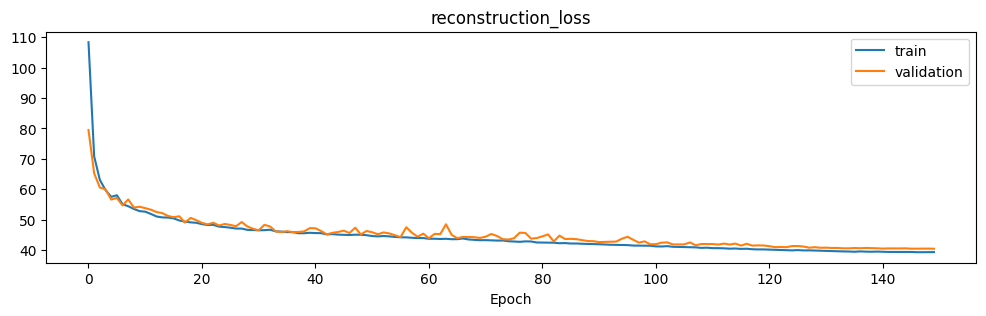

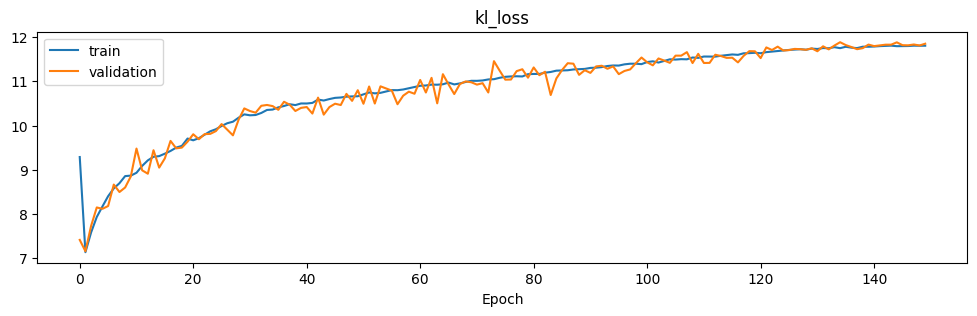

In [12]:
plot_learning_curves(metrics, ["reconstruction_loss"])
plot_learning_curves(metrics, ["kl_loss"])



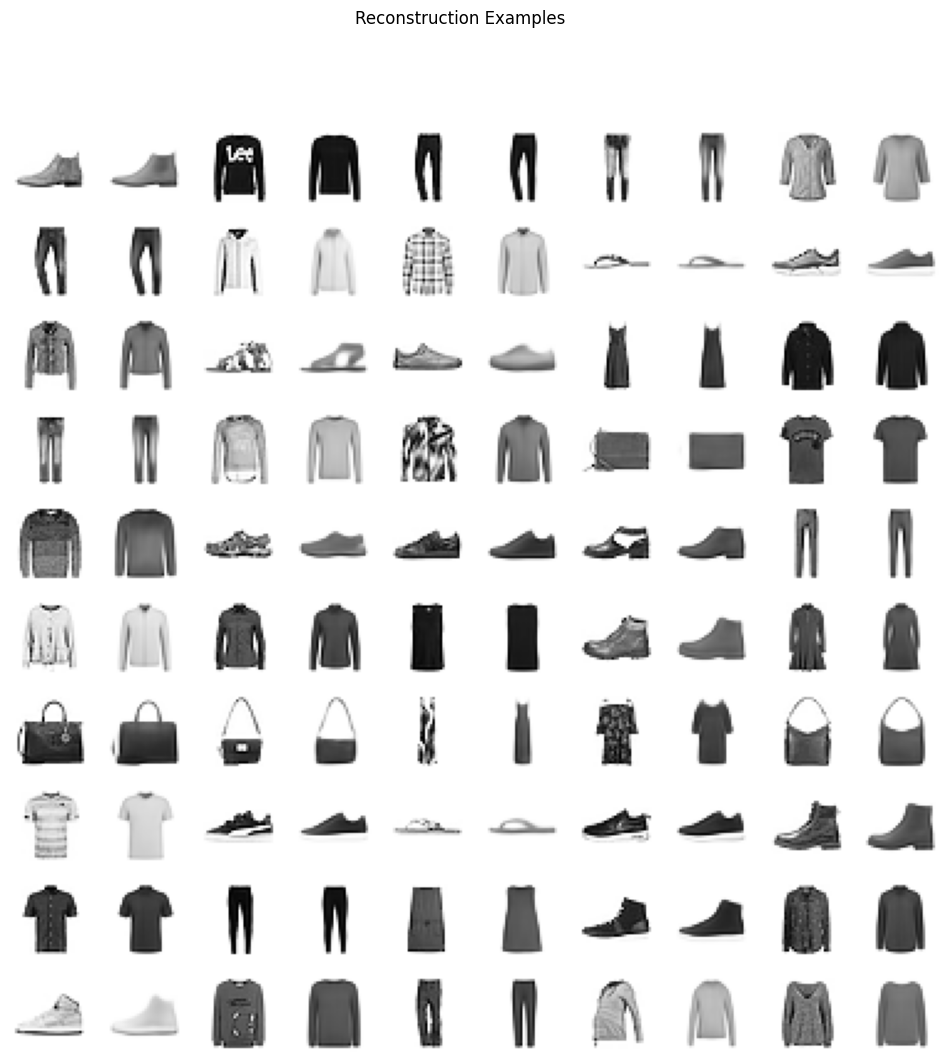

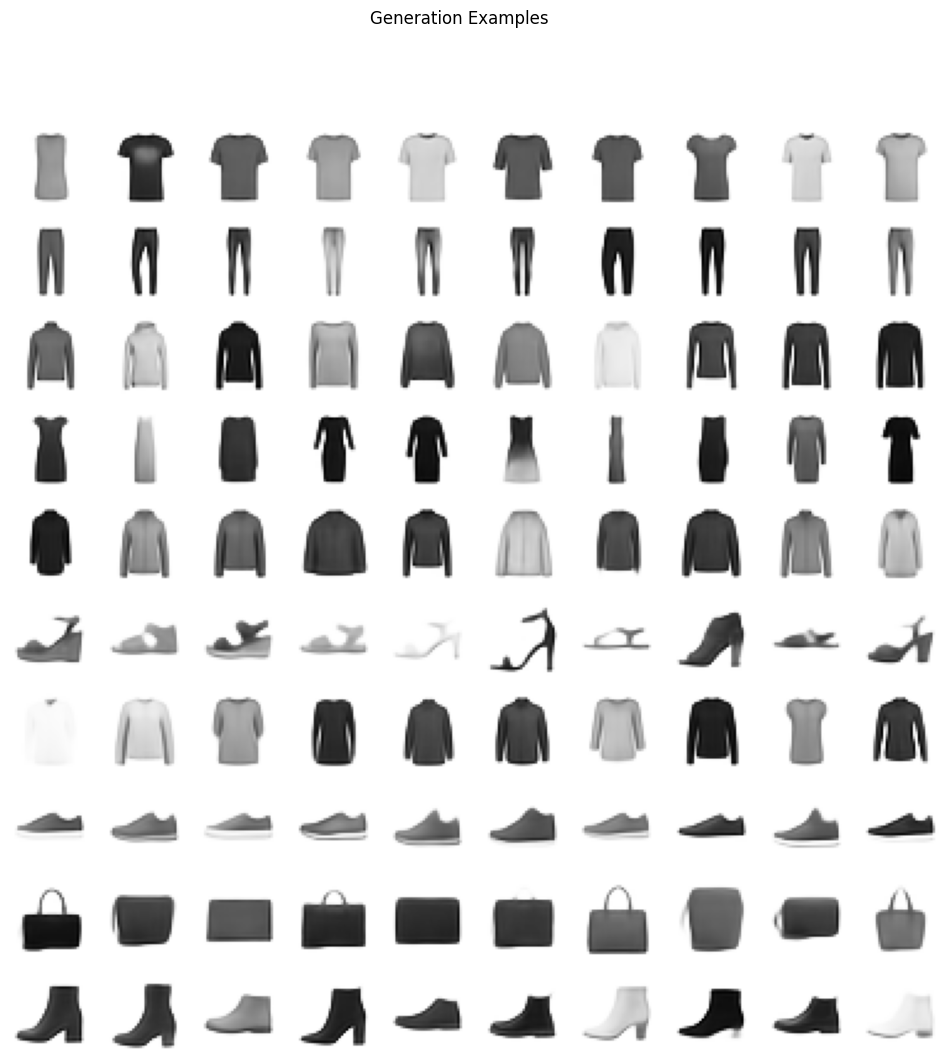

In [13]:
trainer.plot_examples()

## GANs Model Training

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def create_gan_model(train_dataloader, batch_size):
    level_filters = [32, 64, 128]  
    level_strides = [1, 2, 2]  
    blocks_per_level = [2, 2, 2]  
    kernel_size = 3
    activation = nn.Mish
    n_levels = len(level_filters)

    disc_global_pool = True  # whether the final convolutional feature maps are pooled before flattening to a vector
    gen_unflatten = True  # whether the generator noise is created as a vector (True), or directly in image shape (False)
    # e.g. as vector it would sth like shape (128,).
    # in "image shape" it would be sth like (128, 4, 4) so 4x4 pixels.

    input_shape = next(iter(train_dataloader))[0].shape[1:]
    input_pixels = input_shape[1]
    final_pixels = input_pixels // (2**(n_levels-1))

    input_channels = input_shape[0]
    final_filters = level_filters[-1] 

    # recipe for a fairly standard residual block + squeeze-and-excite (use_se)
    block_fn = ConvBlockPrenorm
    block_kwargs = {
        "n_layers": 2,
        "activation": activation,
        "kernel_size": kernel_size,
        "use_se": True,
        "se_reduction_factor": 8,
        "se_bias": 1.,
        "use_residual": True,
        "bottleneck_factor": 1
    }

    # NOTE that we supply nn.GroupNorm for the normalization, replacing the BatchNorm default!
    # passing -8 to norm_groups will be interpreted as creating groups of 8 filters (instead of 8 groups total).
    disc_initial = nn.Conv2d(input_channels, level_filters[0], kernel_size, padding="same")
    disc_body = CNNBody(blocks_per_level,
        level_filters,
        level_strides,
        input_channels=level_filters[0],
        direction="down",
        block_fn=block_fn,
        return_all=True,
        norm=nn.GroupNorm,
        norm_groups=-8,
        **block_kwargs
    )
    disc_head = nn.Sequential()
    if disc_global_pool:
        disc_head.append(nn.AdaptiveAvgPool2d(1))
    disc_head.append(nn.Flatten())
    disc_head.append(nn.LazyLinear(1))

    discriminator = Discriminator(disc_initial, disc_body, disc_head)

    # in case of gen_unflatten: The total dimensionality of the noise
    # in case of gen_unflatten is False: The number of *channels* in the noise "image"
    noise_dim = 128

    if gen_unflatten:
        noise_shape = (noise_dim,)
    else:
        noise_shape = (noise_dim, final_pixels, final_pixels)

    # you can experiment with other random functions! anything goes! no backpropagation needed!
    def noise_fn(batch_size):
        return torch.randn(batch_size, *noise_shape)

    generator = Generator(noise_fn)
    if gen_unflatten:
        generator.append(nn.Linear(noise_dim, final_pixels * final_pixels * final_filters))
        generator.append(Reshape((-1, final_filters, final_pixels, final_pixels)))
    else:
        generator.append(nn.Conv2d(noise_dim, final_filters, 1))
    # for the generator, batchnorm is OK
    generator.append(
        CNNBody(
            blocks_per_level,
            list(reversed(level_filters)),
            list(reversed(level_strides)),
            input_channels=final_filters,
            direction="up",
            block_fn=block_fn,
            **block_kwargs
        )
    )
    generator.append(nn.Conv2d(level_filters[0], input_channels, 1))
    generator.append(nn.Tanh())

    # we have to run the model once to initialize the lazy layers
    discriminator = discriminator.to(device)
    generator = generator.to(device)
    with torch.no_grad():
        d_test_output = discriminator(next(iter(train_dataloader))[0].to(device))
        g_test_output = generator.generate(batch_size)

    print("\n")
    print("discrminator test output shape")
    print(d_test_output[0].shape)
    print("generator test output shape")
    print(g_test_output.shape)
    if g_test_output.shape[1] != input_channels:
        print("WARNING! Expected {} output channels but got {}".format(input_channels, g_test_output.shape[1]))
    if g_test_output.shape[2] != input_pixels:
        print("WARNING! Expected {} output pixels but got {}".format(input_pixels, g_test_output.shape[2]))

    model = GAN(generator, discriminator)
    return model


## GAN Model Trained with MSE Loss

In [ ]:
data = "fashion"
batch_size = 256
train_data, test_data, train_dataloader, test_dataloader = get_datasets_and_loaders(data, batch_size, num_workers=16,
                                                                                    additional_transforms=[Normalize(0.5, 0.5)],
                                                                                    plot_descale=descale_data)

gan_model = create_gan_model(train_dataloader,batch_size)

num_params = count_parameters(gan_model.discriminator)
print(f"Discriminator with {num_params:,} trainable parameters")

num_params = count_parameters(gan_model.generator)
print(f"Generator with {num_params:,} trainable parameters")


n_epochs = 150

optimizer = torch.optim.AdamW(gan_model.parameters(), weight_decay=0.1, amsgrad=False)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

gan_trainer = GANTrainer(model=gan_model,
                     optimizer=optimizer, scheduler=scheduler,
                     training_loader=train_dataloader, validation_loader=test_dataloader,
                     n_epochs=n_epochs, device=device, plot_every_n_epochs=10, verbose=True,
                     plot_descale=descale_data, d_loss_fn = nn.MSELoss())

gan_metrics = gan_trainer.train_model()

In [33]:
gan_model.eval()
torch.save(gan_model.state_dict(), 'gan_model_weights.pth')


## GAN Model Trained with feature matching

In [ ]:
data = "fashion"
batch_size = 256

def descale_data(imgs):
    return 0.5 * (imgs + 1)


gan_model = create_gan_model(train_dataloader,batch_size)

num_params = count_parameters(gan_model.discriminator)
print(f"Discriminator with {num_params:,} trainable parameters")

num_params = count_parameters(gan_model.generator)
print(f"Generator with {num_params:,} trainable parameters")


n_epochs = 150

optimizer = torch.optim.AdamW(gan_model.parameters(), weight_decay=0.1, amsgrad=False)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

gan_trainer_feature_matching = GANTrainer(model=gan_model,feature_matching = "sum",
                     optimizer=optimizer, scheduler=scheduler,
                     training_loader=train_dataloader, validation_loader=test_dataloader,
                     n_epochs=n_epochs, device=device, plot_every_n_epochs=10, verbose=True,
                     plot_descale=descale_data, d_loss_fn = nn.MSELoss())

gan_metrics_feature_matching = gan_trainer_feature_matching.train_model()

In [39]:
gan_model.eval()
torch.save(gan_model.state_dict(), 'gan_model_feature_weights.pth')


## Loading weights of all three trained models

In [88]:
gan_model = create_gan_model(train_dataloader,batch_size)
gan_feature_model = create_gan_model(train_dataloader,batch_size)
conditional_vae = build__vae(CONDITIONAL = True)
unconditional_conditional_vae = build__vae(CONDITIONAL = False)

gan_feature_model.load_state_dict(torch.load("gan_model_feature_weights.pth", map_location=device))
gan_feature_model.to(device)
gan_feature_model.eval()

gan_model.load_state_dict(torch.load("gan_model_weights.pth", map_location=device))
gan_model.to(device)
gan_model.eval()

conditional_vae.load_state_dict(torch.load("vae_model_weights.pth", map_location=device))
conditional_vae.to(device)
conditional_vae.eval()


unconditional_conditional_vae.load_state_dict(torch.load("unconditional_vae_model_weights.pth", map_location=device))
unconditional_conditional_vae.to(device)
unconditional_conditional_vae.eval()



discrminator test output shape
torch.Size([256, 1])
generator test output shape
torch.Size([256, 1, 32, 32])


discrminator test output shape
torch.Size([256, 1])
generator test output shape
torch.Size([256, 1, 32, 32])
Using cuda device

test output shape
torch.Size([256, 1, 32, 32]) 

Using cuda device

test output shape
torch.Size([256, 1, 32, 32]) 



ConditionalVAEGauss(
  (encoder): ConditionalNet(
    (root): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (body): CNNBody(
      (levels): ModuleList(
        (0): CNNLevel(
          (blocks): ModuleList(
            (0): ConvBlockPrenorm(
              (first_norm): BNWrap2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (layers): Sequential(
                (0): Mish()
                (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (2): BNWrap2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (3): Mish()
                (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
              )
              (squeeze_excite): SqueezeExcite(
                (mapper): Sequential(
                  (0): Linear(in_features=32, out_features=4, bias=True)
                  (1): Mish()
                  (2): Linear(in_features

# Model Evaluation

In this section, we compare the performance of **four different types of generative models** to answer the question:

> Do GANs outperform VAEs in terms of generated sample quality?

To investigate this, we trained the following models:

1. **Conditional VAE** – a VAE trained with class labels to condition the generation process.  
2. **Unconditional VAE** – a VAE trained without class labels.  
3. **Standard GAN** – a GAN trained with a squared loss function.  
4. **GAN with Feature Matching** – a GAN trained with squared loss and feature matching to stabilize training.

We will evaluate and compare these models using **FID** and **Inception Score**.


#### Assign function names to variables to generate a batch of different samples through four different models.

In [104]:
classifier = get_classifier(data, "weights").to(device)

feature_extractor = classifier[:-3]
classifier.eval()
feature_extractor.eval()
head = classifier[-3:]
head.eval()


def generate_conditional(batch_size = 256):
    classes = torch.randint(0, n_classes, size=(batch_size,))
    return torch.clamp(conditional_vae.generate(conditioning=classes), 0, 1)


def generate_unconditional(batch_size = 256):
    return torch.clamp(unconditional_conditional_vae.generate(batch_size), 0, 1)


def generate_gan_(batch_size = 256):
    return torch.clamp(gan_model.generator.generate(batch_size), 0, 1)

def generate_gan_feature(model, batch_size = 256):
    return torch.clamp(gan_feature_model.generator.generate(batch_size), 0, 1)#
    
generate_feature_gan = generate_gan_feature
generate_gan = generate_gan_
generate_vae = generate_conditional
generate_unconditional_vae = generate_unconditional



### Example Generated Samples from GAN Models

GANs feature matching


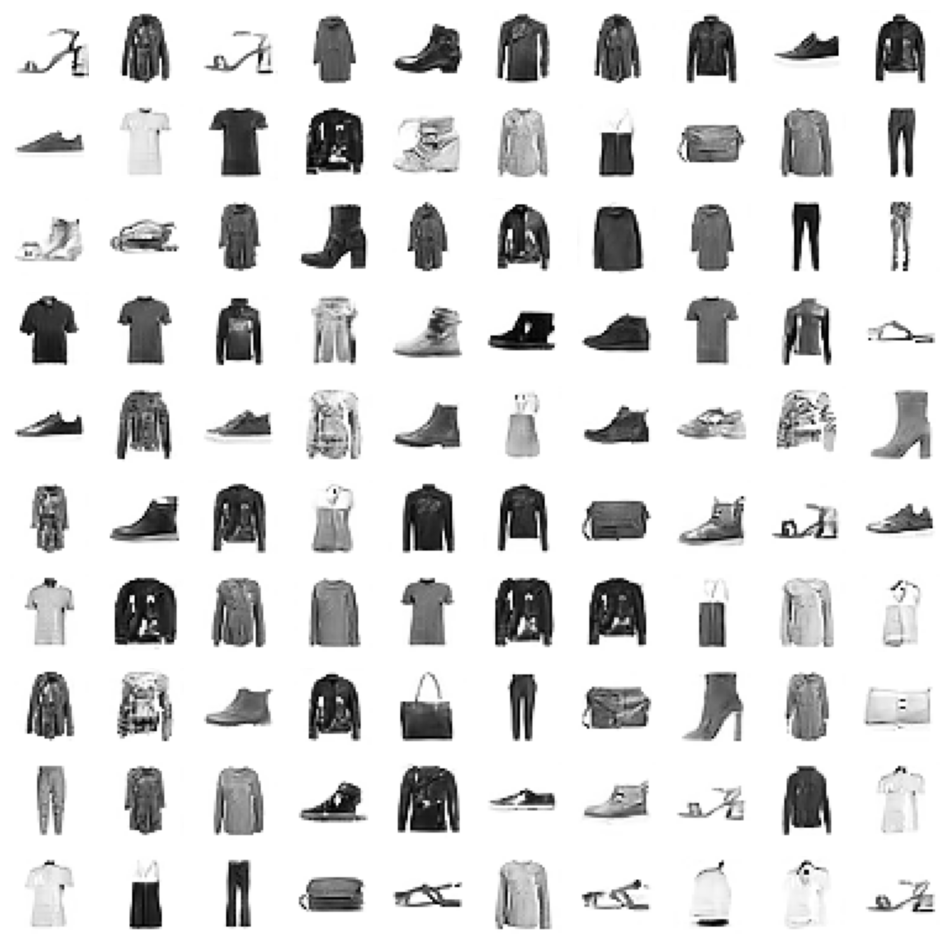

GANs


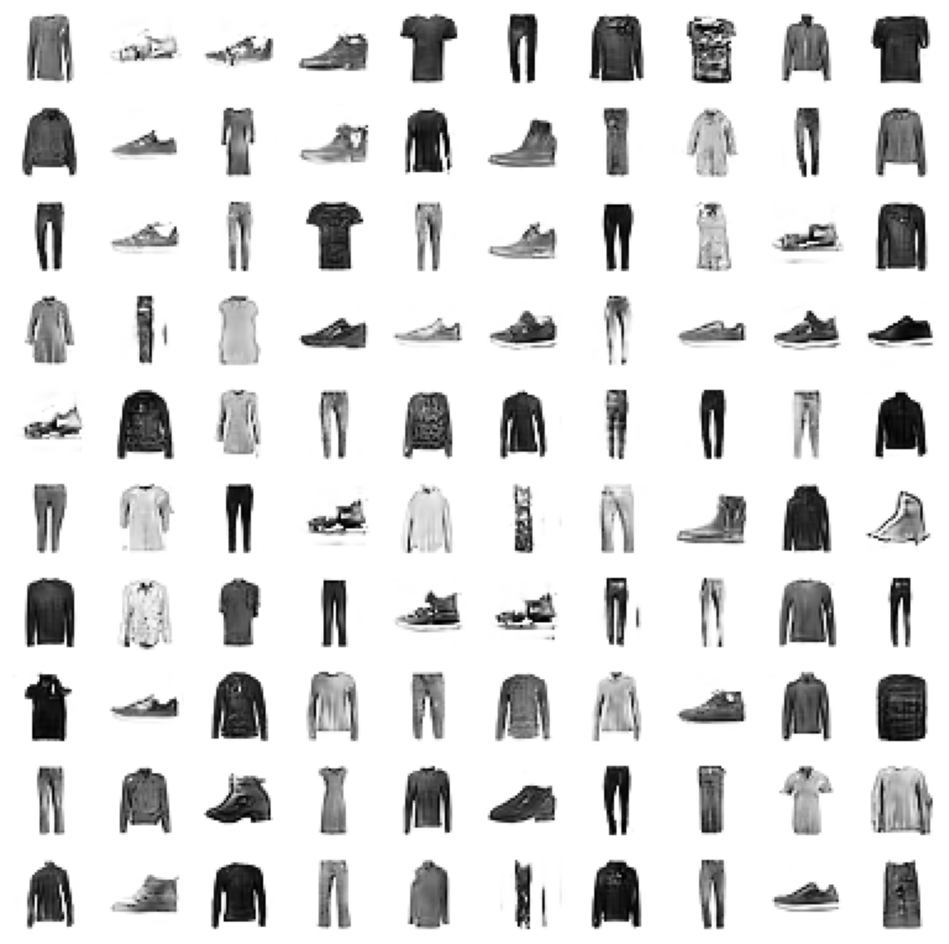

In [94]:
def generate_images(grid_size=(10, 10), figsize=(12, 12),generator = None):   
    with torch.no_grad():
        generated = descale_data(generator.generate(np.prod(grid_size)))
        generated = generated.cpu().numpy().transpose(0, 2, 3, 1)
        
    plt.figure(figsize=figsize)
    for ind, img in enumerate(generated):
        plt.subplot(*grid_size, ind + 1)
        plt.imshow(img, cmap="Greys", vmin=0, vmax=1)
        plt.axis("off")
    plt.show()

generators = [
    (gan_feature_model.generator, "GANs feature matching"),
    (gan_model.generator, "GANs"),
]

for gen, title in generators:
    print(title)
    generate_images(grid_size=(10, 10), figsize=(12, 12),generator =  gen)



### Compute FID Scores and Extract Features

In this section, we compute the **FID** for all our models and also extract the corresponding features for further analysis.


In [98]:

fid_result_unconditional_vae, real_features_unconditional_vae, gen_features_unconditional_vae = fid(feature_extractor, test_dataloader_vae, generate_unconditional_vae, n_samples=50000, return_features=True,
                                              use_tqdm=True)

fid_result_unconditional_vae

Computing real features:   0%|          | 0/40 [00:00<?, ?it/s]

Computing generated features:   0%|          | 0/195 [00:00<?, ?it/s]

np.float64(64.10048252553997)

In [109]:
fid_result_gan_featur, real_features_gan_featur, gen_features_gan_feature = fid(feature_extractor, test_dataloader, generate_feature_gan, n_samples=50000, return_features=True,
                                              use_tqdm=True)
fid_result_gan, real_features_gan, gen_features_gan = fid(feature_extractor, test_dataloader, generate_gan, n_samples=50000, return_features=True,
                                              use_tqdm=True)
fid_result_vae, real_features_vae, gen_features_vae = fid(feature_extractor, test_dataloader_vae, generate_vae, n_samples=50000, return_features=True,
                                              use_tqdm=True)

fid_result_unconditional_vae, real_features_unconditional_vae, gen_features_unconditional_vae = fid(feature_extractor, test_dataloader_vae, generate_unconditional_vae, n_samples=50000, return_features=True,
                                              use_tqdm=True)

Computing real features:   0%|          | 0/40 [00:00<?, ?it/s]

Computing generated features:   0%|          | 0/195 [00:00<?, ?it/s]

Computing real features:   0%|          | 0/40 [00:00<?, ?it/s]

Computing generated features:   0%|          | 0/195 [00:00<?, ?it/s]

Computing real features:   0%|          | 0/40 [00:00<?, ?it/s]

Computing generated features:   0%|          | 0/195 [00:00<?, ?it/s]

Computing real features:   0%|          | 0/40 [00:00<?, ?it/s]

Computing generated features:   0%|          | 0/195 [00:00<?, ?it/s]

In [110]:
print(f"FID Score for LGANs using feature matching {fid_result_gan_featur}")
print(f"FID Score for LGANs {fid_result_gan}")
print(f"FID Score for conditional VAE {fid_result_vae}")
print(f"FID Score for unconditional VAE {fid_result_unconditional_vae}")

print(f"Inception Score for LGANs using feature matching {inception_score_with_features(head, gen_features_gan_feature, batch_size)}")
print(f"Inception Score for LGANs {inception_score_with_features(head, gen_features_gan, batch_size)}")
print(f"Inception Score for conditional VAE {inception_score_with_features(head, gen_features_vae, batch_size)}")
print(f"Inception Score for unconditional VAE {inception_score_with_features(head, gen_features_unconditional_vae, batch_size)}")

FID Score for LGANs using feature matching 128.80694285536993
FID Score for LGANs 145.63886892760945
FID Score for conditional VAE 34.93333564909926
FID Score for unconditional VAE 64.42962136743904
Inception Score for LGANs using feature matching 5.201676384051495
Inception Score for LGANs 4.817257742495034
Inception Score for conditional VAE 6.763137457601445
Inception Score for unconditional VAE 5.8898964819289725


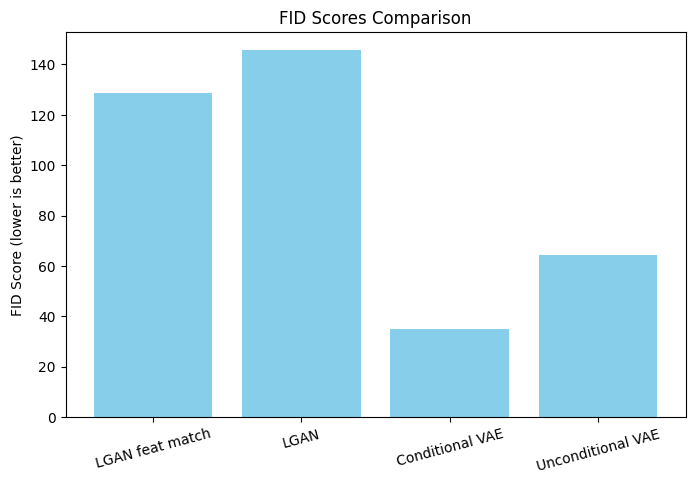

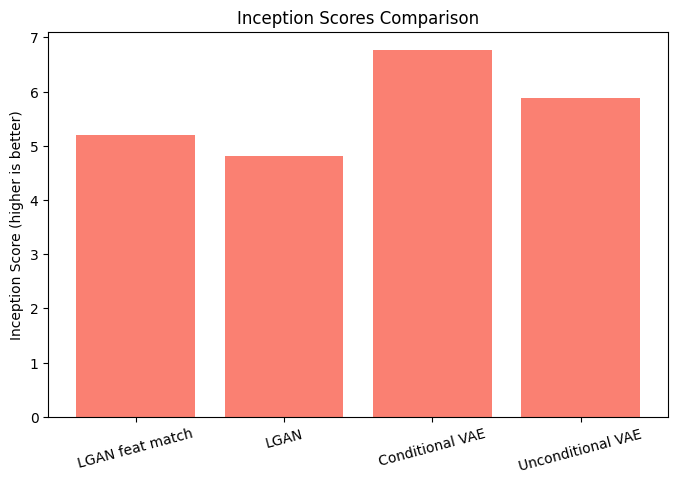

In [111]:
import matplotlib.pyplot as plt

models = [
    "LGAN feat match", 
    "LGAN", 
    "Conditional VAE", 
    "Unconditional VAE"
]

fid_scores = [
    fid_result_gan_featur,
    fid_result_gan,
    fid_result_vae,
    fid_result_unconditional_vae
]

inception_scores = [
    inception_score_with_features(head, gen_features_gan_feature, batch_size),
    inception_score_with_features(head, gen_features_gan, batch_size),
    inception_score_with_features(head, gen_features_vae, batch_size),
    inception_score_with_features(head, gen_features_unconditional_vae, batch_size)
]

plt.figure(figsize=(8, 5))
plt.bar(models, fid_scores, color='skyblue')
plt.ylabel("FID Score (lower is better)")
plt.title("FID Scores Comparison")
plt.xticks(rotation=15)
plt.show()

plt.figure(figsize=(8, 5))
plt.bar(models, inception_scores, color='salmon')
plt.ylabel("Inception Score (higher is better)")
plt.title("Inception Scores Comparison")
plt.xticks(rotation=15)
plt.show()


# Experiment Observations

- **FID Scores:**  
  The LGAN achieved the best FID score among all models, indicating that its generated images are closest to the real data distribution. In contrast, both the Conditional VAE and Unconditional VAE had significantly higher FID scores, showing that their outputs are less realistic.

- **Inception Scores:**  
  The Conditional VAE achieved the highest Inception Score, likely because it was trained with class labels, resulting in more diverse and recognizable samples. Among the GANs, the LGAN with feature matching produced the most diverse results, outperforming the standard GAN in terms of sample variety.
